In [1]:
import numpy as np
import matplotlib.pyplot as plt

 ## skyrms2010signals_fig1-1

We import  the `asymmetric_games` module, which is the one that has the `Chance`class. We use this class to set up games with a chance player ("nature").

In [2]:
from skyrms import asymmetric_games as asy

In order to instantiate the `Chance` class we need probabilities for the chance player, sender and receiver payoff matrices, and the number of available messages.

In [3]:
states = np.array([.5, .5])
sender_payoff_matrix = np.eye(2)
receiver_payoff_matrix = np.eye(2)
messages = 2

In [4]:
lewis22 = asy.Chance(states, sender_payoff_matrix, receiver_payoff_matrix, messages)

Now, in order to evolve this game, we need to decide which sender and receiver strategies we are going to use.
A common choice would be all pure strategies. For example, for the sender:

In [5]:
lewis22.sender_pure_strats()

array([[[1., 0.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

And ditto for the receiver. But, for this example, Skyrms (2010, p. 10) only wants to consider non-pooling strategies (those for which senders send different signals for different states, and receivers perform different acts for different signals). So, we take pooling strategies out:

In [6]:
sender_strats = lewis22.sender_pure_strats()[1:-1]
receiver_strats = lewis22.receiver_pure_strats()[1:-1]

OK, now we need to evolve this, using a two-population replicator dynamics. This is in the `evolve` module.

In [7]:
from skyrms.evolve import TwoPops

In [8]:
two_pop = TwoPops(lewis22, sender_strats, receiver_strats)

We can do a bunch of things with this object, but right now what we want to do is take a bunch of proportions of sender strategies, and proportions of receiver strategies, and evolve them one discrete step, then plot the result.

`two_pop` can generate a random sender (receiver) frequency vector:

In [9]:
rand_sender = two_pop.random_sender()
rand_receiver = two_pop.random_receiver()

... and then evolve these frequencies using the replicator dynamics:

In [10]:
# There's this weird thing that I keep concatenating and dividing the vector of sender and receiver freqs.
# I don't remember why I did that, but it's something to look into.
two_pop.discrete_replicator_delta_X(np.concatenate((rand_sender, rand_receiver)))

array([0.3084, 0.6916, 0.3084, 0.6916])

But we want our frequencies to be neatly spaced in a 15x15 grid (in order to replicate Skyrms's figure)

In [11]:
freqs = np.linspace(0.01, .99, 15)
# This below just adds the complementary to 1 to each value, 
# so that we have a full freq vector
senders = np.vstack((freqs, 1 - freqs)).T 
receivers = np.vstack((freqs, 1 - freqs)).T

In order to draw our vector field, we need velocities.

Thas is to say, a function that takes 

1. the frequency of the first sender strategy, and 
2. the frequency of the first receiver strategy

and returns

1. the change in frequency of the first sender strategy
2. the change in frequency of the second sender strategy

This function is not in the `skyrms` library. Should it?

In [12]:
def uv_from_xy(x, y):
    senders = np.array([x, 1 - x])
    receivers = np.array([y, 1 - y])
    new_pop_vector = two_pop.discrete_replicator_delta_X(np.concatenate((senders, receivers)))
    new_senders, new_receivers = two_pop.vector_to_populations(new_pop_vector)
    return (1-x) - new_senders[1], (1-y) - new_receivers[1]

And now we just use `matplotlib.pyplot.quiver`

In [13]:
X, Y = np.meshgrid(freqs, freqs)

In [14]:
U, V = np.vectorize(uv_from_xy)(X, Y)

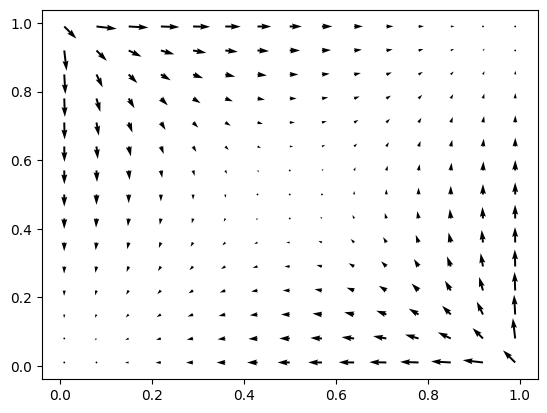

In [15]:
fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, scale=20, )
plt.show()

 ## skyrms2010signals_fig1-2

On page 11 of _Signals_, Skyrms describes a variant on the above game:

> Consider a one-population model where the agent’s contingency plans, *if sender... and if receiver...* correspond to the four corners of the model we just considered. The dynamics lives on a tetrahedron.

To construct this population, notice that there are four variants:
1. When sender play strat 0, when receiver play strat 0
2. When sender play strat 0, when receiver play strat 1
3. When sender play strat 1, when receiver play strat 0
4. When sender play strat 1, when receiver play strat 1

We're going to create a one-population model using `evolve.OnePop()` to simulate the evolution of these four types. 
What `OnePop()` needs is a `Game()` object and what we might call an interaction payoff matrix.

The interaction payoff matrix takes each of the four types and says what its payoff would be if it were to meet each of the other four types.
So it's a 4x4 array, like the following.

In [16]:
## Set up
import numpy as np

## Initialize
## Create interaction payoff matrix 
payoffs = np.array(
    [
        [1,0.5,0.5,0], # Payoffs received by type 1 when encountering types 1, 2, 3, 4
        [0.5,0,1,0.5], # Payoffs received by type 2 when encountering types 1, 2, 3, 4
        [0.5,1,0,0.5], # Payoffs received by type 3 when encountering types 1, 2, 3, 4
        [0,0.5,0.5,1]  # Payoffs received by type 4 when encountering types 1, 2, 3, 4
    ]
)

## And the player types are all of the pure strategies,
##  which just means four vectors each saying "strategy 1", "strategy 2" etc
playertypes = np.array(
    [
        [1,0,0,0], # "I'm playing the first strategy!"
        [0,1,0,0], # "I'm playing the second strategy!"
        [0,0,1,0], # "I'm playing the third strategy!"
        [0,0,0,1]  # "I'm playing the fourth strategy!"
    ]
)

And the funny thing is we don't even need to use a *signalling* game here.
The strategies and payoffs are kind of "fixed" by the `playertypes` array.

So we can just create a symmetric, non-signalling game with these payoffs.

In [17]:
from skyrms.symmetric_games import NoSignal

game = NoSignal(payoffs)

And we feed the game into the `OnePop` along with the `playertypes` array...

...or we would do if there wasn't a bug in `NoSignal`.
The following code, if uncommented and executed in Python 3.11.0, throws an error.
The reason is that it's trying to step through an array and get the payoffs at that point in the array (sender i, receiver j), but the types of i and j are `float` rather than `int`.

In [18]:
from skyrms.evolve import OnePop
#one_pop = OnePop(game,playertypes)

Instead, we'll quickly rig up our own `NoSignal` class and overwrite the bug.

In [19]:
class NoSignalFixed(NoSignal):
    def avg_payoffs(self, player_strats):
        """
        Return an array with the average payoff of strat i against
        strat j in position <i, j>
        """
        payoff_ij = np.vectorize(lambda i, j: self.payoff(player_strats[int(i)],
                                                          player_strats[int(j)]))
        shape_result = [len(player_strats)] * 2
        return np.fromfunction(payoff_ij, shape_result)

## Now recreate the game with the fixed version of the method
game = NoSignalFixed(payoffs)

## And create the OnePop
one_pop = OnePop(game,playertypes)

Great! Now we can get some data points in order to plot the tetrahedron.

We need a way to translate from the population vector to the three-dimensional tetrahedron coordinates.
The population vector is four-dimensional.
We can use the barycentric coordinate formula. 
I found it here: https://math.stackexchange.com/a/3354099

In [20]:
## Tetrahedron vertices
vertices = np.array([
    [1,1,5],          # summit
    [0,0,0],            # bottom left
    [2,2,0],            # bottom right
    [1.75,4.5,0]           # back
])

def vector_to_barycentric(
        vector
        ):
    """
    Convert a 4d vector location to its equivalent within a tetrahedron

    Parameters
    ----------
    vector : TYPE
        DESCRIPTION.

    Returns
    -------
    barycentric_location : TYPE
        DESCRIPTION.

    """

    ## Initialise

    ## Normalise vector v to get vector u
    u = vector / vector.sum()

    ## Multiply vector u by the tetrahedron coordinates 
    barycentric_location = u @ vertices

    return barycentric_location

We want to create some arrows at roughly the positions where Skyrms plots them.
First, specify the population vectors corresponding to those arrows.

In [21]:
pop_vectors = np.array([
        [0.75,0.25,0,0], # left edge, pointing upward, upper
        [0.25,0.75,0,0], # left edge, pointing upward, lower
        [0,0.75,0.25,0], # bottom edge, pointing inward from left
        [0,0.25,0.75,0], # bottom edge, pointing inward from right
        [0.75,0,0,0.25], # back edge, top third, facing up
        [0.25,0,0,0.75], # back edge, bottom third, facing down
        [0,0.25,0,0.75], # back-bottom edge, close to the back vertex
        [0,0,0.25,0.75]  # front-bottom edge, close to the back vertex (this arrowhead doesn't come out very clearly)
    ])

From these starting population vectors, we want to know where the population would go.
That's what will determine the size and direction of the arrows.

I will come back and use `np.vectorize()` on this, I promise!
But for now I am using a for-loop, because it's kinder to my brain.

In [22]:
## See what the "new" pop vectors are.
## Do a for-loop for now.
## Later we will vectorize it.
pop_vectors_new = one_pop.discrete_replicator_delta_X(pop_vectors[0])

for i in range(1,len(pop_vectors)):
    pop_vectors_new = np.vstack(
        (pop_vectors_new,
         one_pop.discrete_replicator_delta_X(pop_vectors[i])
         )
    )

Now for the barycentric magic: we convert those 4-dimensional population vectors into 3-dimensional points, and generate "population velocities" -- depicted as arrows -- from the differences between the new population locations and the old ones.

In [23]:
## Get barycentric coordinates for the original population positions
test_pop_vector_bary = np.apply_along_axis(
                        vector_to_barycentric,
                        axis=1,
                        arr=pop_vectors)

## Get barycentric coordinates for new population positions
new_pop_vector_bary     = np.apply_along_axis(
                        vector_to_barycentric,
                        axis=1,
                        arr=pop_vectors_new)

## ... then get the difference between that and the current step.
arrows = new_pop_vector_bary - test_pop_vector_bary

And it's all over bar the shouting.

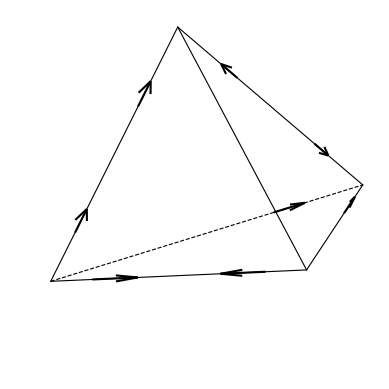

In [24]:
import matplotlib.pyplot as plt

## There's probably a nicer way to do this.
## But I am adapting some code I copied and pasted from elsewhere.
soa = np.hstack((test_pop_vector_bary,arrows))
X, Y, Z, U, V, W = zip(*soa)

## Create the figure object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

## Plot the 3D quiver plot.
## Parameters at https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html#mpl_toolkits.mplot3d.axes3d.Axes3D.quiver
ax.quiver(X, Y, Z, U, V, W,
          color = 'k',
           normalize=True,
          length = 0.5,
          arrow_length_ratio = 0.5,
          pivot = 'middle'
          )

## Set the limits of the three axes.
ax.set_xlim([-0.05, 2.1])
ax.set_ylim([-0.05, 3.05])
ax.set_zlim([-0.05, 3.05])

## Remove the axes, because Skyrms's plot doesn't include them.
ax.set_axis_off()

## Draw the edges of the tetrahedron.
## This bit was also "borrowed" from StackExchange.
from itertools import combinations
lines=combinations(vertices,2)
i=0
for x in lines:
    i+=1
    line=np.transpose(np.array(x))

    ## Make the back line a double dash
    linestyle = '--' if i == 5 else '-'

    ## https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html#mpl_toolkits.mplot3d.axes3d.Axes3D.plot3D
    ax.plot3D(
        line[0],
        line[1],
        line[2],
        c='0',
        linestyle = linestyle,
        linewidth = 0.8
        )

## Show the thing.
plt.show()

All that's left is to draw the separating surface in the middle of the tetrahedron.